In [ ]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh_V/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_cal/"
res_DIR = "../data/results_cal/"

In [ ]:
parameter_values = get_parameter_values()
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [ ]:
cell = 22
# cell = 23

In [ ]:
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)

In [ ]:
# C_n_init,C_p_init,x_init,y_init,c_rate_c,c_rate_d,dis_set = init_exp(cell_no,dfe)
param = spm.param
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)

In [ ]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*250 ,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [ ]:
Temp = [25,45,-5]
k_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,10]
# d_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,100]
d_sei = [1,1e-1,1e1,1e-2,1e2,1e-3,1e3,1e-4,1e4]

In [ ]:
ksei_idx = 0
dsei_idx = 0
Temp_idx = 1

In [ ]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp[Temp_idx],
        "Ambient temperature [K]": 273.15+Temp[Temp_idx],
        "SEI growth activation energy [J.mol-1]": 5000,
    },
    check_already_exists=False,
)

In [ ]:
# parameter_values.search("SEI")

In [ ]:
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [ ]:
fig = plotc(all_sumvars_dict,dfe);
plt.savefig(fig_DIR +'calendar_aging_cell_'+cell_no+'_eSOH.png')

In [ ]:
dasdas

In [ ]:
Temp_idx = 2

In [ ]:
parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
            "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
            "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
            "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
            "Initial temperature [K]": 273.15+Temp[Temp_idx],
            "Ambient temperature [K]": 273.15+Temp[Temp_idx],
        },
        check_already_exists=False,
    )

In [ ]:
all_sumvars_dict_1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
fig = plotcomp(all_sumvars_dict,all_sumvars_dict_1);

In [ ]:
parameter_values.search("SEI growth")

In [ ]:
parameter_values.search("temperature")

In [ ]:
dfe={}
cell = 22
cell_no,dfe[0],N = load_data_calendar(cell,eSOH_DIR)
cell = 24
cell_no,dfe[1],N = load_data_calendar(cell,eSOH_DIR)

In [ ]:
dfl={}
dfl[0]=all_sumvars_dict
dfl[1]=all_sumvars_dict_1

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI"]
for ev_num in range(len(esoh_vars)):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    col = ['r','b','k','g','c']
    # for k in range(len(dfl)):
    for k in [0,1]:
        ax.plot(dfl[k]['Cycle number'],dfl[k][esoh_vars[ev_num]],color=col[k],marker='v')
        ax.plot(dfe[k]['N'],dfe[k][esoh_vars[ev_num]],color=col[k],marker='x')
        ax.set_title(split_long_string(esoh_vars[ev_num]))
    fig.legend(['45 C Sim','45 C data','-5 C Sim','-5 C data'], 
               loc="lower center",bbox_to_anchor=[0.5,-0.3], ncol=2, fontsize=11)
    plt.savefig(fig_DIR+'sens_comp1_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'_comp_'+esoh_vars_str[ev_num]+'.png')

## Compare plain calendar aging with the one with RPT

In [ ]:
cell = 22
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)

In [ ]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16, #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
    },
    check_already_exists=False,
)

In [ ]:
pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*250 ,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [ ]:
# sim_rpt = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
sim_normal = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_normal = sim_normal.solve(initial_soc=1)
sol_normal_output =sol_normal.summary_variables

In [ ]:
sol_normal_output['Cycle number']

In [ ]:
pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
calendar_time = 24*40
dis_set = " until 3V"
c_rate_d = 'C/20'
c_rate_c = 'C/20'
experiment_rpt = pybamm.Experiment(
    [
        "Rest for "+f'{calendar_time}'+" hours",
        ("Discharge at "+c_rate_d+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c+" until 4.2V"), 
    ]*6 ,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [ ]:
# sim_rpt = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
sim_rpt = pybamm.Simulation(spm, experiment=experiment_rpt, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_rpt = sim_rpt.solve(initial_soc=1)
sol_rpt_output =sol_rpt.summary_variables

In [ ]:
lensol_rpt_output['Cycle number'][::2]

In [ ]:
np.arange(0,6)

In [ ]:
def plotcomp(all_sumvars_dict0,all_sumvars_dict1):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict0["Cycle number"][::20],all_sumvars_dict0[name][::20],"kx")
        # ax.plot(40*all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"bx")
        ax.plot(40*np.arange(1,7),all_sumvars_dict1[name][::2],"ro")

        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Baseline"] + ["Rpt"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
fig = plotcomp(sol_normal_output,sol_rpt_output)
plt.savefig(fig_DIR+'sim_comp_normal_rpt_c20'+'.png')

In [ ]:
pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
calendar_time = 24*40
dis_set = " until 3V"
c_rate_d = '1C'
c_rate_c = '1C'
c_rate_d1 = 'C/20'
c_rate_c1 = 'C/20'
experiment_rpt = pybamm.Experiment(
    [
        "Rest for "+f'{calendar_time}'+" hours",
        ("Discharge at "+c_rate_d+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Discharge at "+c_rate_d1+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c1+" until 4.2V"), 
    ]*6 ,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [ ]:
# sim_rpt = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
sim_rpt1 = pybamm.Simulation(spm, experiment=experiment_rpt, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_rpt1 = sim_rpt1.solve(initial_soc=1)
sol_rpt_output1 =sol_rpt1.summary_variables

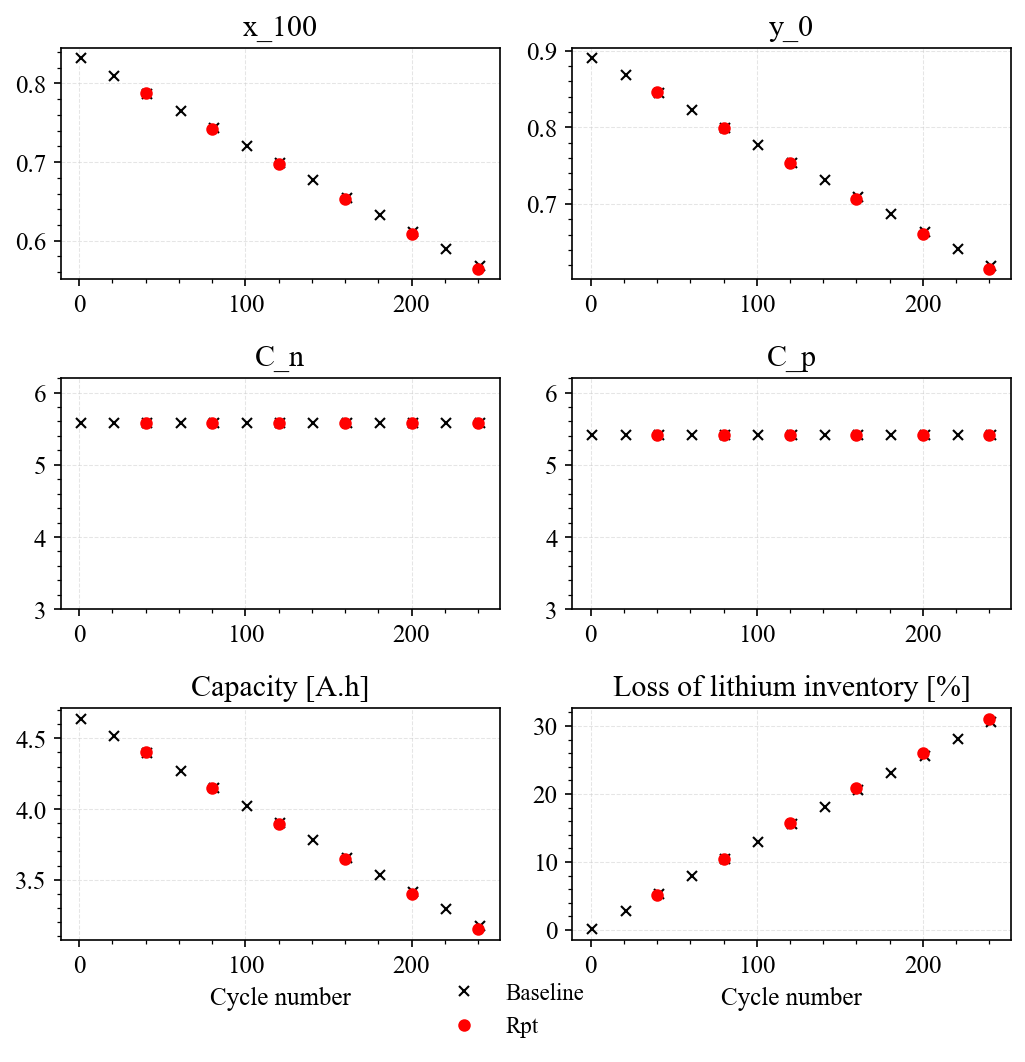

In [70]:
fig = plotcomp(sol_normal_output,sol_rpt_output1)
plt.savefig(fig_DIR+'sim_comp_normal_rpt_c1'+'.png')

In [68]:
def plotcomplong(all_sumvars_dict0,all_sumvars_dict1,all_sumvars_dict2):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict0["Cycle number"][::40],all_sumvars_dict0[name][::40],"kx--")
        # ax.plot(40*all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"bx")
        ax.plot(40*np.arange(1,7),all_sumvars_dict1[name][::2],"ro")
        ax.plot(40*np.arange(1,7),all_sumvars_dict2[name][::2],"gv")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Normal"] + ["Rpt C/20"] + ["Rpt C/20 + 1C"], 
            loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

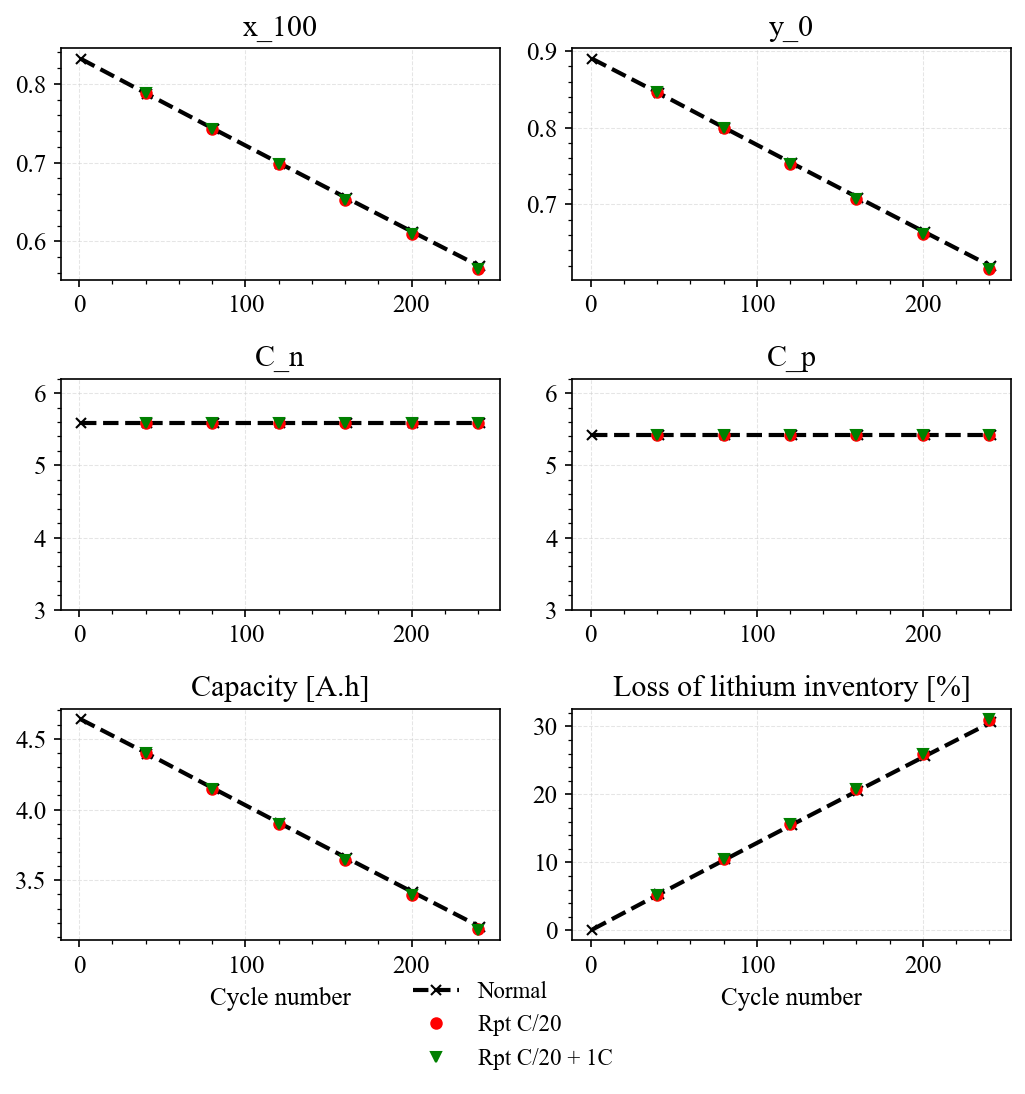

In [69]:
fig = plotcomplong(sol_normal_output,sol_rpt_output,sol_rpt_output1)
plt.savefig(fig_DIR+'sim_comp_normal_rpt_comp'+'.png')